# Schritt 4: Binäre Klassifikation
•	Trainieren Sie ein separates binäres CNN-Modell für die ausgewählte Klasse und alle anderen Klassen. Dieses Modell soll Autos erkennen, ob ein Bild zur ausgewählten Klasse gehört oder nicht.


In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
import tensorflow as tf

In [2]:
# Laden des CIFAR-10-Datasets
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Normalisieren der Bildpixel auf den Bereich [0, 1]
X_train = X_train.astype(np.float32) / 255.
X_test = X_test.astype(np.float32) / 255.

# Umwandlung der Labels in binäre Klassifikation (Auto oder Nicht-Auto)
y_train = y_train == 1
y_test = y_test == 1

Text(0.5, 1.0, 'Class distribution in training set')

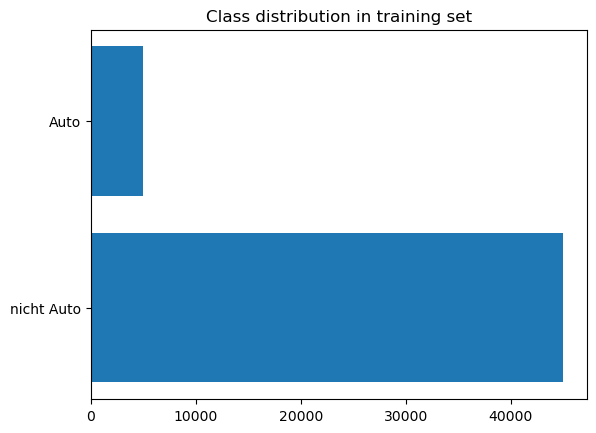

In [3]:
classes_name = ['nicht Auto', 'Auto']

classes, counts = np.unique(y_train, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in training set')

Text(0.5, 1.0, 'Class distribution in testing set')

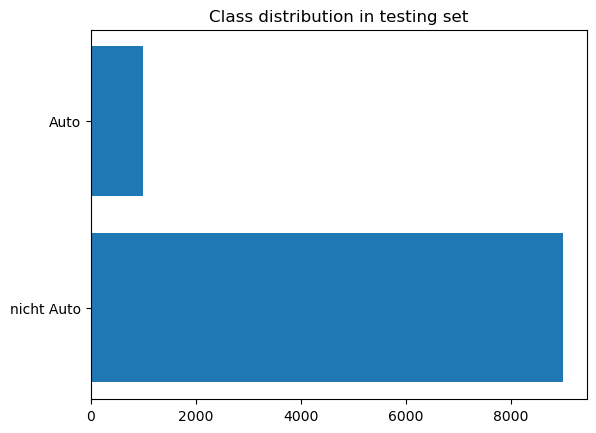

In [4]:
classes, counts = np.unique(y_test, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in testing set')

In [5]:
# Das Modell designen
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(32, 32, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer="adam", loss='binary_crossentropy', metrics=["accuracy"])
model.summary()

early_stop = EarlyStopping(monitor='val_loss',patience=10)
history = model.fit(X_train, y_train, batch_size=150, epochs=50, validation_data=(X_test, y_test),callbacks=[early_stop])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 64)          0

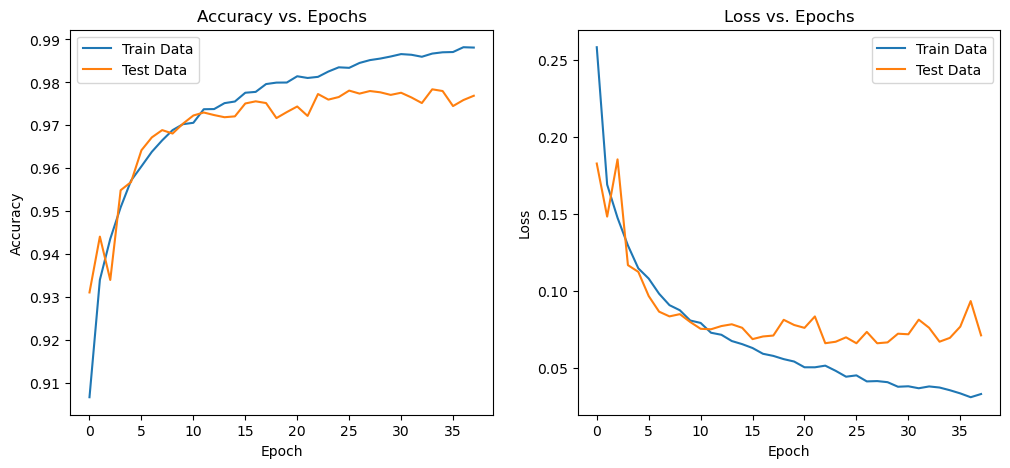

In [6]:
# Trainingsergebnisse visualisieren (Genauigkeit und Verlust)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Data')
plt.plot(history.history['val_accuracy'], label='Test Data')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Data')
plt.plot(history.history['val_loss'], label='Test Data')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')

plt.show()

313/313 [==============================] - 4s 11ms/step


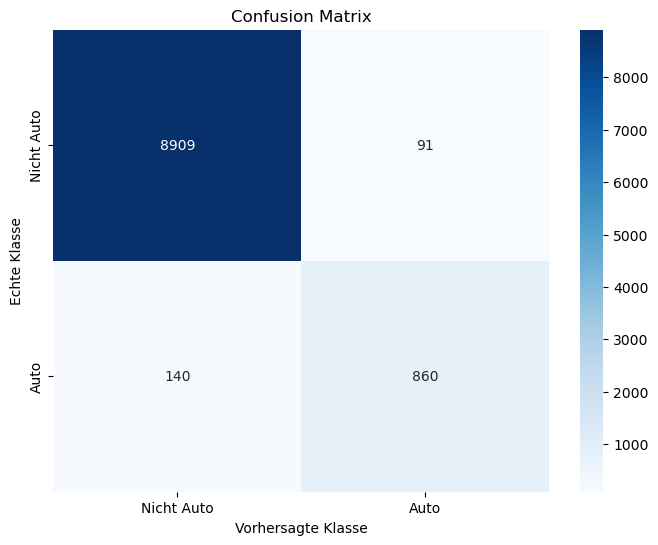

In [7]:
# Vorhersagen für die Testdaten erstellen
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)  # Schwellenwert von 0.5 für binäre Vorhersagen

# Confusion Matrix erstellen
cm = confusion_matrix(y_test, y_pred)
# Anzeige der Confusion Matrix mit seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Nicht Auto', 'Auto'], yticklabels=['Nicht Auto', 'Auto'])
plt.xlabel('Vorhersagte Klasse')
plt.ylabel('Echte Klasse')
plt.title('Confusion Matrix')
plt.show()

313/313 [==============================] - 2s 5ms/step


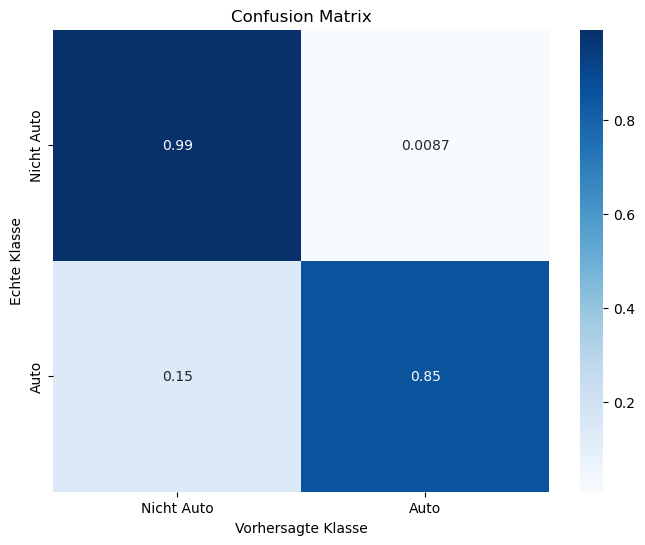

In [6]:
# Vorhersagen für die Testdaten erstellen
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)  # Schwellenwert von 0.5 für binäre Vorhersagen

# Confusion Matrix erstellen
cm = confusion_matrix(y_test, y_pred, normalize="true")
# Anzeige der Confusion Matrix mit seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['Nicht Auto', 'Auto'], yticklabels=['Nicht Auto', 'Auto'])
plt.xlabel('Vorhersagte Klasse')
plt.ylabel('Echte Klasse')
plt.title('Confusion Matrix')
plt.show()

In [8]:
# Berechnen Sie den Klassifikationsbericht
report = classification_report(y_test, y_pred, target_names=['Nicht Auto', 'Auto'])


# Drucken Sie den Klassifikationsbericht
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

  Nicht Auto       0.98      0.99      0.99      9000
        Auto       0.90      0.86      0.88      1000

    accuracy                           0.98     10000
   macro avg       0.94      0.92      0.93     10000
weighted avg       0.98      0.98      0.98     10000



# Schritt 5: Data Augmentation für unausgeglichene Klassen
•	Da Sie unausgeglichene Klassen haben (eine Klasse ist positiv, die anderen sind negativ), wenden Sie Data Augmentation auf die negativen Klassen an, um die Datenbasis auszugleichen. Verwenden Sie Techniken wie Rotation, Verschiebung, Spiegelung, Zoom und Helligkeitsanpassung, um synthetische Beispiele zu generieren.


In [8]:
# Das Modell designen
gen = ImageDataGenerator(
    width_shift_range=3, 
    height_shift_range=3, 
    zoom_range=0.1, 
    horizontal_flip=True,)

gen.fit(X_train)

new_model = Sequential()
new_model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(32, 32, 3), activation="relu"))
new_model.add(MaxPooling2D(pool_size=(2, 2)))
new_model.add(Dropout(0.25))

new_model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
new_model.add(MaxPooling2D(pool_size=(2, 2)))
new_model.add(Dropout(0.25))

new_model.add(Conv2D(128, kernel_size=(3, 3), activation="relu"))
new_model.add(MaxPooling2D(pool_size=(2, 2)))
new_model.add(Dropout(0.25))

new_model.add(Flatten())
new_model.add(Dense(256, activation="relu"))
new_model.add(Dense(1, activation="sigmoid"))

new_model.compile(optimizer="adam", loss='binary_crossentropy', metrics=["accuracy"])
new_model.summary()

early_stop = EarlyStopping(monitor='val_loss',patience=10)
#call back csv_logger
new_history = new_model.fit(gen.flow(X_train, y_train, batch_size=150, shuffle=True),
                        epochs=50,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stop])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 6, 6, 64)         

Epoch 42/50
334/334 [==============================] - 39s 118ms/step - loss: 0.0633 - accuracy: 0.9780 - val_loss: 0.0504 - val_accuracy: 0.9816
Epoch 43/50
334/334 [==============================] - 39s 117ms/step - loss: 0.0645 - accuracy: 0.9776 - val_loss: 0.0560 - val_accuracy: 0.9809
Epoch 44/50
334/334 [==============================] - 40s 120ms/step - loss: 0.0615 - accuracy: 0.9777 - val_loss: 0.0521 - val_accuracy: 0.9819
Epoch 45/50
334/334 [==============================] - 40s 119ms/step - loss: 0.0623 - accuracy: 0.9772 - val_loss: 0.0498 - val_accuracy: 0.9822
Epoch 46/50
334/334 [==============================] - 40s 120ms/step - loss: 0.0598 - accuracy: 0.9784 - val_loss: 0.0517 - val_accuracy: 0.9823
Epoch 47/50
334/334 [==============================] - 40s 120ms/step - loss: 0.0615 - accuracy: 0.9781 - val_loss: 0.0496 - val_accuracy: 0.9813
Epoch 48/50
334/334 [==============================] - 39s 117ms/step - loss: 0.0616 - accuracy: 0.9780 - val_loss: 0.0531 -

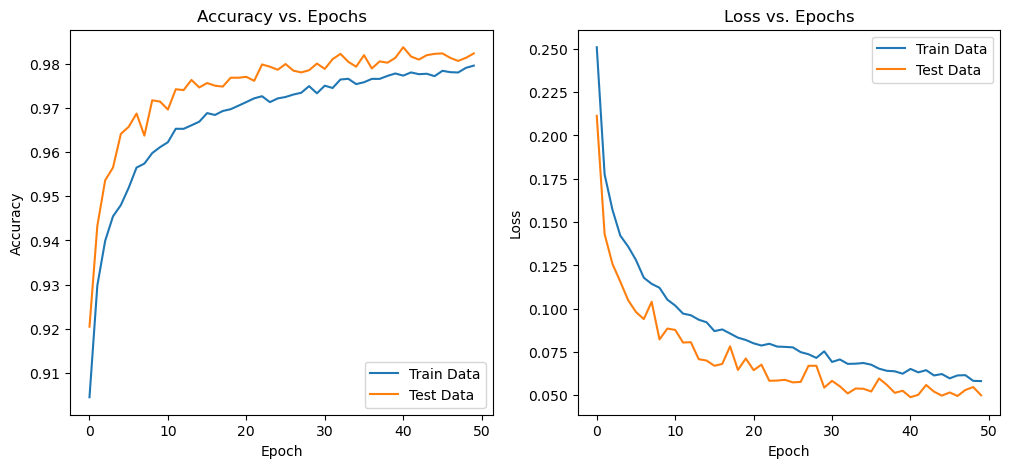

In [9]:
# Trainingsergebnisse visualisieren (Genauigkeit und Verlust)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(new_history.history['accuracy'], label='Train Data')
plt.plot(new_history.history['val_accuracy'], label='Test Data')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(new_history.history['loss'], label='Train Data')
plt.plot(new_history.history['val_loss'], label='Test Data')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')

plt.show()

313/313 [==============================] - 2s 5ms/step


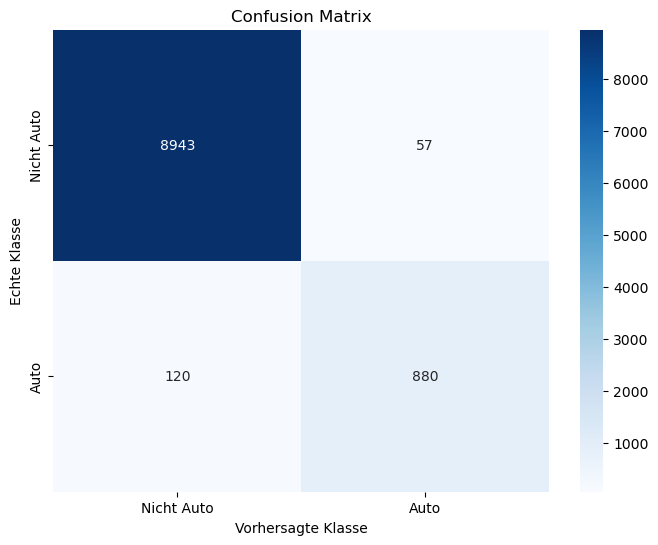

In [10]:
# Vorhersagen für die Testdaten erstellen
y_pred = new_model.predict(X_test)
y_pred = (y_pred > 0.5)  # Schwellenwert von 0.5 für binäre Vorhersagen

# Confusion Matrix erstellen
cm = confusion_matrix(y_test, y_pred)
# Anzeige der Confusion Matrix mit seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Nicht Auto', 'Auto'], yticklabels=['Nicht Auto', 'Auto'])
plt.xlabel('Vorhersagte Klasse')
plt.ylabel('Echte Klasse')
plt.title('Confusion Matrix')
plt.show()

313/313 [==============================] - 2s 5ms/step


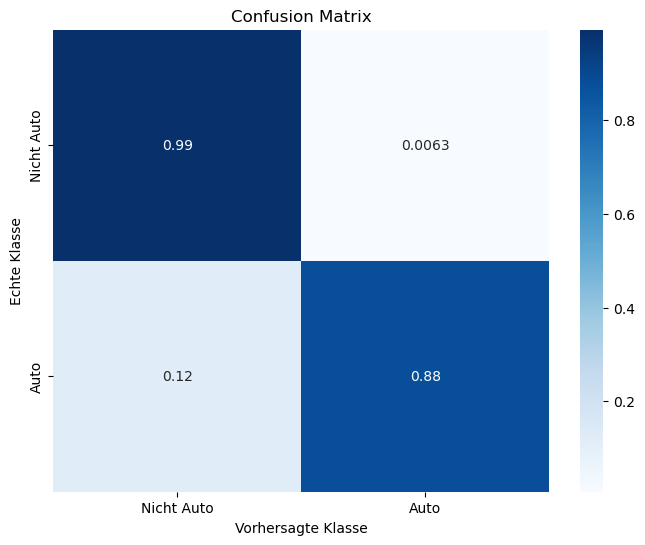

In [11]:
# Vorhersagen für die Testdaten erstellen
y_pred = new_model.predict(X_test)
y_pred = (y_pred > 0.5)  # Schwellenwert von 0.5 für binäre Vorhersagen

# Confusion Matrix erstellen
cm = confusion_matrix(y_test, y_pred, normalize="true")
# Anzeige der Confusion Matrix mit seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['Nicht Auto', 'Auto'], yticklabels=['Nicht Auto', 'Auto'])
plt.xlabel('Vorhersagte Klasse')
plt.ylabel('Echte Klasse')
plt.title('Confusion Matrix')
plt.show()


In [12]:
# Berechnen Sie den Klassifikationsbericht
report = classification_report(y_test, y_pred, target_names=['Nicht Auto', 'Auto'])


# Drucken Sie den Klassifikationsbericht
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

  Nicht Auto       0.99      0.99      0.99      9000
        Auto       0.94      0.88      0.91      1000

    accuracy                           0.98     10000
   macro avg       0.96      0.94      0.95     10000
weighted avg       0.98      0.98      0.98     10000



In [13]:

# Umwandlung der Labels in binäre Klassifikation (Auto oder Nicht-Auto)
# Statt y_train und y_test auf boolsche Werte zu setzen
# Verwende die ursprünglichen Labels (0 und 1)
y_train = (y_train == 1).astype(np.int32)
y_test = (y_test == 1).astype(np.int32)

# Prüfen wie viele Labels es gibt
classes, counts = np.unique(y_train, return_counts=True)
print(classes)
print(counts)

# Die Klassen mit class_weight ausbalancieren
# Klassen die seltener vertreten sind, sollen stärker gewichtet werden
class_weights = counts.max()/counts
class_weights = class_weights/class_weights.mean()

class_weights = dict(zip(classes, class_weights))

# Das Modell designen
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(32, 32, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer="adam", loss='binary_crossentropy', metrics=["accuracy"])
model.summary()

early_stop = EarlyStopping(monitor='val_loss',patience=10)
#call back csv_logger
history = model.fit(X_train, y_train, batch_size=150, epochs=50, class_weight=class_weights, validation_data=(X_test, y_test),callbacks=[early_stop])


[0 1]
[45000  5000]
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None

Epoch 42/50
334/334 [==============================] - 25s 76ms/step - loss: 0.0250 - accuracy: 0.9701 - val_loss: 0.0975 - val_accuracy: 0.9654


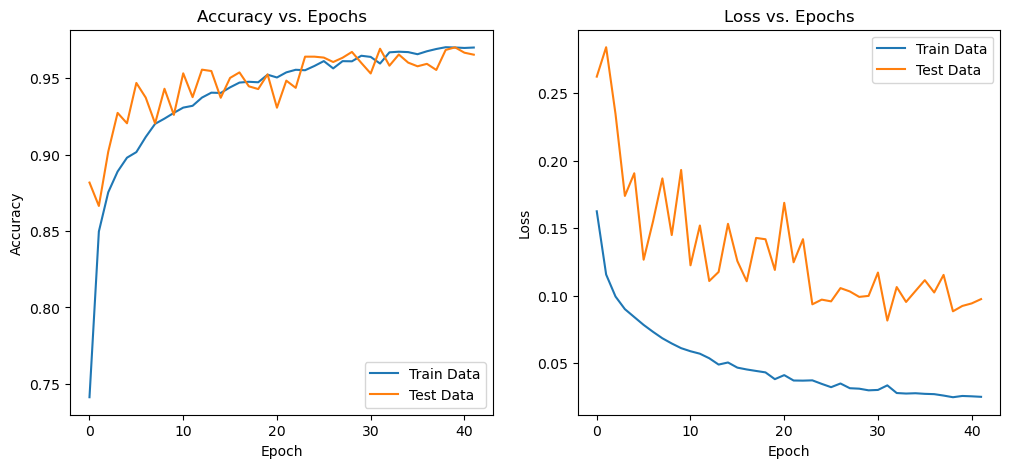

In [14]:
# Trainingsergebnisse visualisieren (Genauigkeit und Verlust)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Data')
plt.plot(history.history['val_accuracy'], label='Test Data')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Data')
plt.plot(history.history['val_loss'], label='Test Data')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')

plt.show()

313/313 [==============================] - 2s 5ms/step


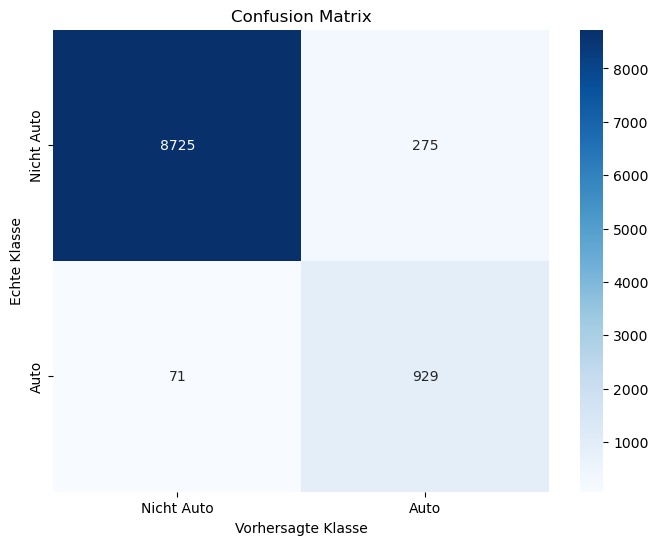

In [15]:
# Vorhersagen für die Testdaten erstellen
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)  # Schwellenwert von 0.5 für binäre Vorhersagen

# Confusion Matrix erstellen
cm = confusion_matrix(y_test, y_pred)
# Anzeige der Confusion Matrix mit seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Nicht Auto', 'Auto'], yticklabels=['Nicht Auto', 'Auto'])
plt.xlabel('Vorhersagte Klasse')
plt.ylabel('Echte Klasse')
plt.title('Confusion Matrix')
plt.show()

313/313 [==============================] - 2s 5ms/step


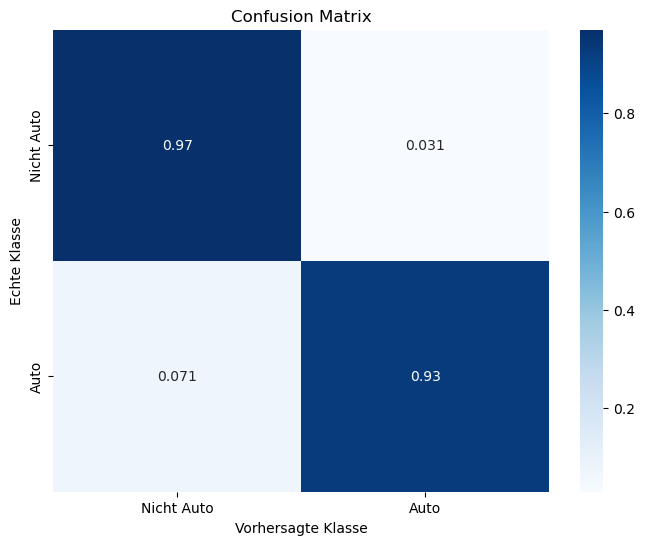

In [16]:
# Vorhersagen für die Testdaten erstellen
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)  # Schwellenwert von 0.5 für binäre Vorhersagen

# Confusion Matrix erstellen
cm = confusion_matrix(y_test, y_pred, normalize="true")
# Anzeige der Confusion Matrix mit seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['Nicht Auto', 'Auto'], yticklabels=['Nicht Auto', 'Auto'])
plt.xlabel('Vorhersagte Klasse')
plt.ylabel('Echte Klasse')
plt.title('Confusion Matrix')
plt.show()


In [17]:
# Berechnen Sie den Klassifikationsbericht
report = classification_report(y_test, y_pred, target_names=['Nicht Auto', 'Auto'])


# Drucken Sie den Klassifikationsbericht
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

  Nicht Auto       0.99      0.97      0.98      9000
        Auto       0.77      0.93      0.84      1000

    accuracy                           0.97     10000
   macro avg       0.88      0.95      0.91     10000
weighted avg       0.97      0.97      0.97     10000



# Schritt 6: Zusammenfassung 
Dieses Projekt bietet die Möglichkeit, Fähigkeiten in der Bildklassifikation, Transfer Learning, Data Augmentation und binären Klassifikation zu entwickeln. Es zeigt auch, wie Sie mit unausgeglichenen Klassen umgehen können, indem Sie Data Augmentation verwenden, um die Leistung Ihres Modells zu verbessern. Viel Erfolg bei Ihrem Projekt!